In [ ]:
# !pip install pandas pymongo bertopic openai --quiet

In [98]:
import os
from pathlib import Path

import numpy as np
import openai
import pandas as pd

from bertopic import BERTopic
from bertopic.representation import OpenAI
from dotenv import load_dotenv
from pymongo import MongoClient, errors

load_dotenv("../.env")

True

# Data extraction

In [2]:
MONGO_DATABASE = 'insightfinder-dev'
MONGO_COLLECTION = 'content'
MONGO_HOST = os.getenv("MONGO_HOST")

In [8]:
def generate_data(query: dict, projection: dict = None, sort_order: list = None, limit: int = None):
    try:
        with MongoClient(MONGO_HOST) as mongo_client:
            db = mongo_client[MONGO_DATABASE]
            collection = db[MONGO_COLLECTION]
            res = collection.find(query, projection or {})
            if sort_order:
                res = res.sort(sort_order)
            if limit:
                res = res.limit(limit)
            yield from res
    except errors.PyMongoError as e:
        self.logger.error(f"MongoDB error: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")


def preprocess_paragraphs(paragraphs):
    if not isinstance(paragraphs, list):
        return None
    return " ".join(p.strip() for p in paragraphs if len(p.strip()) > 0)

In [13]:
query = {"visited": True, "parsed_date": {"$exists": True, "$ne": None, "$gte": "2024-05-20"}}
projection = {"_id": 1, "url": 1, "parsed_date": 1, "title": 1, "description": 1, "paragraphs": 1, "site_name": 1}
sort_order = [("parsed_date", -1)]
limit = None

data_generator = generate_data(query, projection, sort_order, limit)
df = pd.DataFrame(data_generator)
df["paragraphs"] = df["paragraphs"].apply(preprocess_paragraphs)

In [14]:
df

,_id,url,site_name,description,paragraphs,parsed_date,title
0,6652e2489bcb9c2c563cbf1a,https://www.spiegel.de/panorama/taegliches-qui...,spiegel,Jeden Tag gibt es sieben Fragen zu den wichtig...,Jeden Tag um Mitternacht erscheint ein neues Q...,2024-06-05,Das tägliche Quiz vom SPIEGEL
1,665ffef5db6ea3ea26296cab,https://www.faz.net/aktuell/politik/ausland/tv...,faz,In der Debatte: Keri Starmer (links) streitet ...,Für britische Zuschauer sind Wahlkampfduelle i...,2024-06-05,Sandkastenstreit zwischen Sunak und Starmer
2,665ffefadb6ea3ea26296cad,https://www.faz.net/aktuell/politik/krieg-in-n...,faz,Behelfsmäßige Zelte für vertriebene Palästinen...,Nachdem US-Präsident Joe Biden einen möglichen...,2024-06-05,EU macht wegen Friedensplan Druck auf Israel u...
3,665ffefcdb6ea3ea26296cae,https://www.faz.net/aktuell/politik/ausland/sp...,faz,Berlin: Eine Mann trägt während des Gedenkkonz...,Die Polizei in Russlands Hauptstadt Moskau ist...,2024-06-05,Spezialeinsatzkommando stürmt Nawalnyj-Gedenkf...
4,665fffbedb6ea3ea26296cb8,https://www.faz.net/aktuell/wirtschaft/unterne...,faz,Das Unkrautvernichtungsmittel Roundup mit dem ...,Eine Richterin im US-Bundesstaat Pennsylvania ...,2024-06-05,Richterin reduziert Glyphosat-Strafe für Bayer...
...,...,...,...,...,...,...,...
4400,66602349f5ec63d052891b41,https://www.faz.net/aktuell/politik/ausland/na...,faz,Iranische Zeitungen am Morgen nach dem Hubschr...,Nach dem Tod des iranischen Präsidenten Ebrahi...,2024-05-20,Charles Michel kondoliert im Namen der EU
4401,6660234cf5ec63d052891b42,https://www.faz.net/aktuell/politik/ausland/ir...,faz,Absturzstelle in unwegsamen Gelände: Wrack des...,Der iranische Präsident Ebrahim Raisi und sein...,2024-05-20,Iran meldet Tod von Präsident Raisi
4402,6660234ef5ec63d052891b43,https://www.faz.net/aktuell/politik/ausland/we...,faz,Hardliner und Wunschkandidat des Obersten Führ...,Als Ibrahim Raisi 2021 zum Präsidenten gewählt...,2024-05-20,Hardliner und Wunschkandidat des Obersten Führers
4403,66602361f5ec63d052891b4a,https://www.faz.net/aktuell/politik/ausland/ar...,faz,Präsident der Demokratischen Republik Kongo: F...,In der Nacht zu Sonntag hat es in der Demokrat...,2024-05-20,US-Amerikaner und Briten laut Armee an Putschv...


In [15]:
df["site_name"].value_counts()

site_name
faz             1746
spiegel         1742
handelsblatt     514
tagesschau       403
Name: count, dtype: int64

# Topic modelling

In [30]:
def build_documents(records):
    for idx, record in enumerate(records):
        parts = [record.get("title"), record.get("description"), record.get("paragraphs")]
        res = " ".join(p.strip() for p in parts if p is not None and len(p.strip()) > 0)
        if len(res.strip()) > 0:
            yield idx, res

In [31]:
documents = list(build_documents(df[["title", "description", "paragraphs"]].to_dict("records")))
index = [d[0] for d in documents]
documents = [d[1] for d in documents]
len(documents)

4395

In [89]:
pd.Series(documents).apply(lambda t: len(t.split())).describe(np.linspace(0, 1, 11))

count    4395.000000
mean      337.990671
std       315.126816
min         2.000000
0%          2.000000
10%        32.000000
20%        87.000000
30%       135.000000
40%       193.000000
50%       282.000000
60%       340.000000
70%       412.000000
80%       531.000000
90%       714.200000
100%     4072.000000
max      4072.000000
dtype: float64

In [90]:
openai_client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
openai_model = OpenAI(
    openai_client,
    model="gpt-3.5-turbo",
    chat=True,
    tokenizer="char",
    doc_length=500,
    nr_docs=5,
)

topic_model = BERTopic(
    embedding_model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    representation_model=openai_model,
    verbose=True,
)
topics, probs = topic_model.fit_transform(documents)

2024-06-14 11:51:52,036 - BERTopic - Embedding - Transforming documents to embeddings.
/Users/malek/Desktop/Home/Workspaces/Falcony/insightfinder/venv-1/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



Batches:   0%|          | 0/138 [00:00<?, ?it/s]

2024-06-14 11:52:31,424 - BERTopic - Embedding - Completed ✓
2024-06-14 11:52:31,425 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-06-14 11:52:35,392 - BERTopic - Dimensionality - Completed ✓
2024-06-14 11:52:35,393 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-06-14 11:52:35,495 - BERTopic - Cluster - Completed ✓
2024-06-14 11:52:35,498 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|███████████████████████████████████████████| 89/89 [01:08<00:00,  1.29it/s]
2024-06-14 11:53:46,505 - BERTopic - Representation - Completed ✓


/Users/malek/Desktop/Home/Workspaces/Falcony/insightfinder/venv-1/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



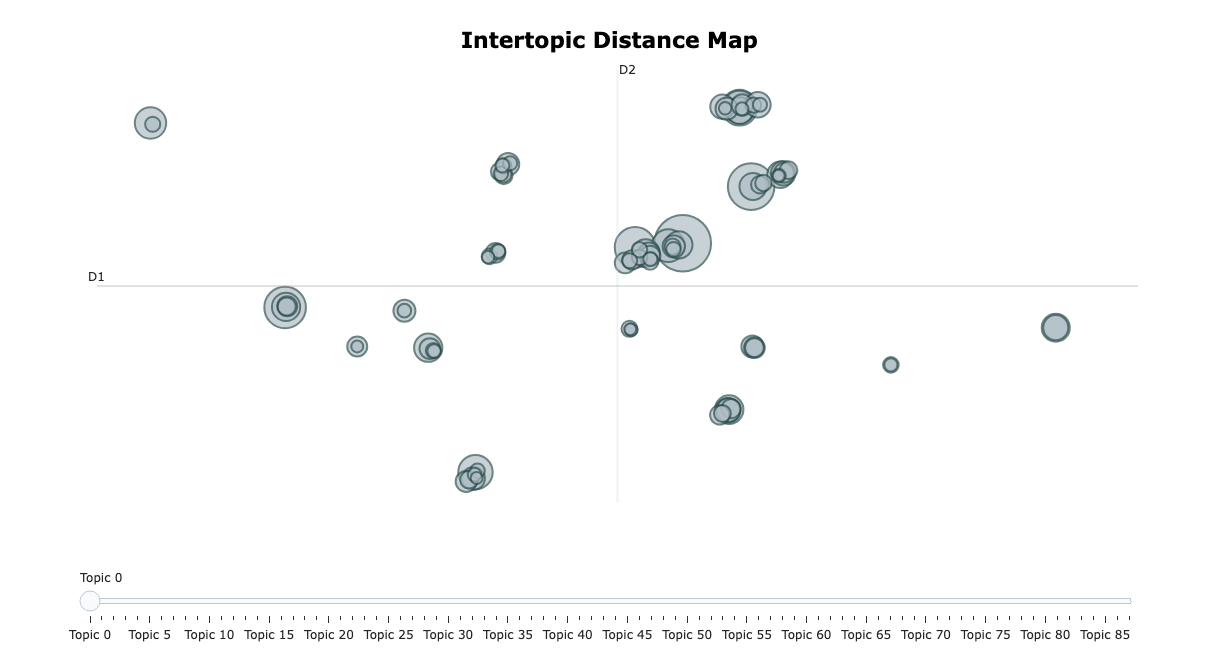

In [91]:
topic_model.visualize_topics()

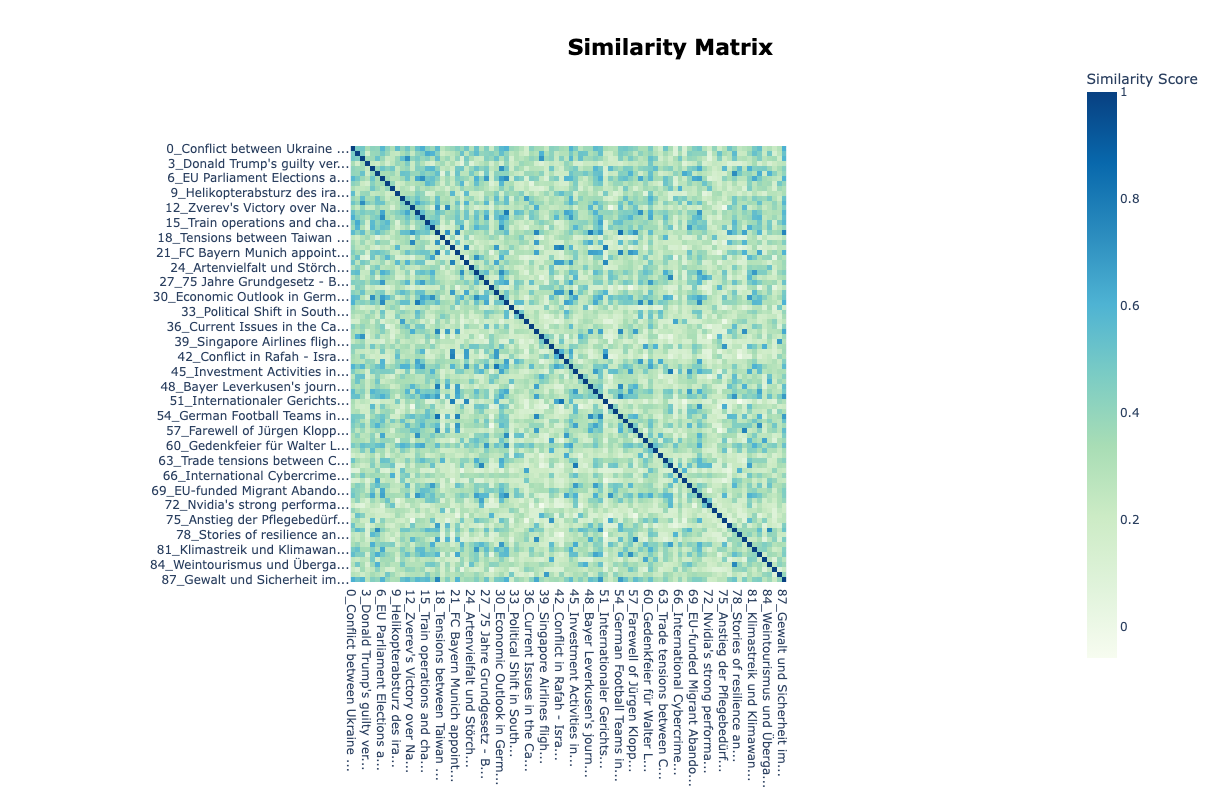

In [92]:
topic_model.visualize_heatmap()

## Topics over time

In [ ]:
openai_client = openai.OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
openai_model = OpenAI(
    openai_client,
    model="gpt-3.5-turbo",
    chat=True,
    tokenizer="char",
    doc_length=500,
    nr_docs=5,
)

topic_model = BERTopic(
    embedding_model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    representation_model=openai_model,
    verbose=True,
)

In [93]:
dates = df.iloc[index]["parsed_date"].tolist()
unique_dates = set(dates)
topics_over_time = topic_model.topics_over_time(documents, dates, nr_bins=len(unique_dates))

/Users/malek/Desktop/Home/Workspaces/Falcony/insightfinder/venv-1/lib/python3.10/site-packages/bertopic/_bertopic.py:775: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.

0it [00:00, ?it/s]
100%|███████████████████████████████████████████| 52/52 [00:44<00:00,  1.16it/s]
1it [00:45, 45.16s/it]
100%|███████████████████████████████████████████| 54/54 [00:46<00:00,  1.17it/s]
2it [01:32, 46.31s/it]
100%|███████████████████████████████████████████| 66/66 [00:51<00:00,  1.29it/s]
3it [02:24, 49.08s/it]
100%|███████████████████████████████████████████| 62/62 [00:48<00:00,  1.27it/s]
4it [03:14, 49.36s/it]
100%|███████████████████████████████████████████| 66/66 [00:54<00:00,  1.22it/s]
5it [04:09, 51.43s/it]
100%|███████████████████████████████████████████| 49/49 [00:39<00:00,  1.2

In [99]:
sd, ed = min(unique_dates), max(unique_dates)
output_path = Path(f"./data/topics_over_time_{sd}_{ed}.csv")
output_path.parent.mkdir(exist_ok=True, parents=True)
topics_over_time.to_csv(output_path, index=False)

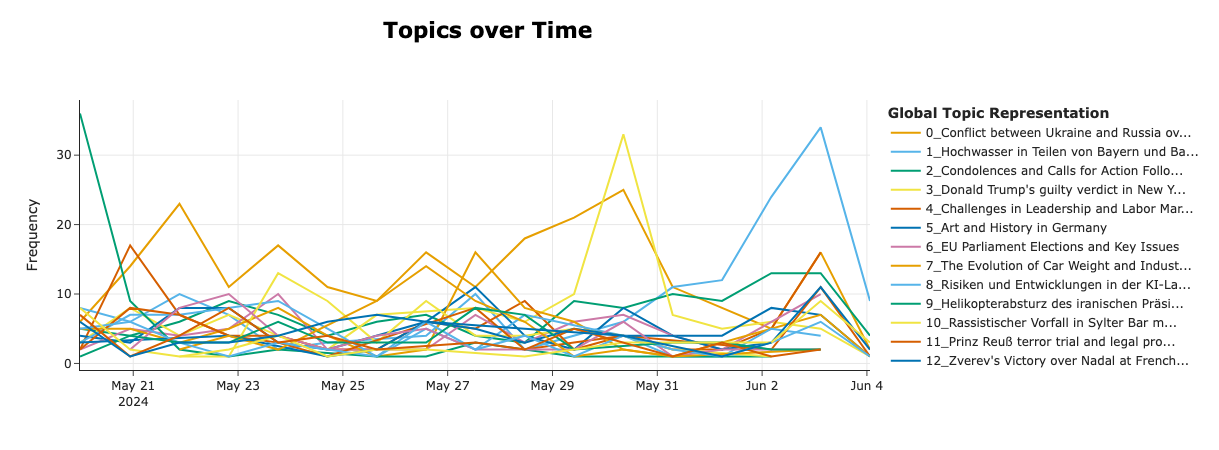

In [95]:
topic_model.visualize_topics_over_time(topics_over_time, top_n_topics=20)